In [19]:
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pickle as pkl
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from IPython.display import Image
import random
from scipy.stats import mannwhitneyu

working_dir = "~/Desktop/hif2gene"

%reload_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
seed = 16
random.seed(seed)

# Pan-Cancer

In [21]:
# Load in pancancer HIF (already cleaned, NA removed)
pancancer_df = pd.read_csv("{0}/data/hifs/pancancer.hifs.labeled.csv".format(working_dir))

# Remove first column
pancancer_df = pancancer_df.drop(columns=['Unnamed: 0'])
pancancer_df.shape # includes HIFs, barcodes, cancer subtype

(2577, 609)

In [22]:
case_ids = pancancer_df[['CASE_ID']] # note: patient-level (one sample per patient)
cancer_subtypes = pancancer_df[['type']]
pancancer_hifs = pancancer_df.iloc[:,1:608]
print(pancancer_hifs.shape)
# pancancer_hifs.columns

(2577, 607)


In [23]:
# Standardize: mean = 0, variance = 1
pancancer_hifs_standardized = StandardScaler().fit_transform(pancancer_hifs)
# pancancer_hifs_standardized

In [24]:
pd.set_option('display.max_colwidth', -1)

pancancer_df_normalized = pd.DataFrame(pancancer_hifs_standardized)
pancancer_df_normalized.columns = pancancer_df.columns[1:608]
pancancer_df_normalized['CASE_ID'] = pancancer_df['CASE_ID']
pancancer_df_normalized['type'] = pancancer_df['type']
# pancancer_df_normalized

/Users/jason.wang/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [25]:
# Load in pancancer HIF clusters
hif_clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
hif_clusters.shape
hif_clusters = hif_clusters.rename(columns={"Unnamed: 0": "HIF", "x": "Cluster Group"})
print(len(set(hif_clusters['Cluster Group'])))

20


In [26]:
# Generate HIF to cluster map
hif2cluster = {}
for ind in hif_clusters.index: 
     hif2cluster[hif_clusters['HIF'][ind]] = hif_clusters['Cluster Group'][ind]
# hif2cluster

In [28]:
# Compute HIF distributions per cluster across cancer subtypes
brca_hifs = pancancer_df_normalized[pancancer_df_normalized['type'] == 'BRCA']
luad_hifs = pancancer_df_normalized[pancancer_df_normalized['type'] == 'LUAD']
lusc_hifs = pancancer_df_normalized[pancancer_df_normalized['type'] == 'LUSC']
stad_hifs = pancancer_df_normalized[pancancer_df_normalized['type'] == 'STAD']
skcm_hifs = pancancer_df_normalized[pancancer_df_normalized['type'] == 'SKCM']

medians = []
for hif in brca_hifs.columns[0:607]:
    medians.append([hif, hif2cluster[hif], np.median(brca_hifs[hif]), np.median(luad_hifs[hif]), 
                    np.median(lusc_hifs[hif]), np.median(stad_hifs[hif]), np.median(skcm_hifs[hif])
                   ]
                  )

medians_df = pd.DataFrame(medians, columns=['HIF', 'Cluster', 'BRCA Median', 'LUAD Median', 
                                            'LUSC Median', 'STAD Median', 'SKCM Median']
                         )
# medians_df

In [29]:
def compute_variance(row):
    variance = np.var([row['BRCA Median'], row['LUAD Median'], row['LUSC Median'], 
                       row['STAD Median'], row['SKCM Median']])
    
    return variance

medians_df['Variance'] = medians_df.apply(lambda row: compute_variance(row), axis=1)
# medians_df.sort_values(by='Variance', ascending=False).iloc[1:50,]

In [30]:
# Representative HIFs
rep_hifs = {
    1: 'AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE',
    2: 'AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE',
    3: 'TOTAL [FIBROBLAST CELLS] IN [STROMA]_HE',
    4: 'AREA PROP [[EPITHELIAL] OVER [TUMOR]] IN [TISSUE]_HE',
    5: 'REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF ESI_0080_HE',
    6: 'REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE',
    7: 'DENSITY [MACROPHAGE CELLS] IN [STROMA]_HE',
    8: 'DENSITY [PLASMA CELLS] IN [EPITHELIAL]_HE',
    9: 'DENSITY [PLASMA CELLS] IN [STROMA]_HE',
    10: 'DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_HE',
    11: 'COUNT PROP [LYMPHOCYTE CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE',
    12: 'DENSITY [CANCER CELLS] IN [EPITHELIAL]_HE',
    13: 'DENSITY [CANCER CELLS] IN [STROMA]_HE',
    14: 'DENSITY [FIBROBLAST CELLS] IN [STROMA]_HE',
    15: 'COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE',
    16: 'COUNT PROP [PLASMA CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE',
    17: 'REGION PROPERTIES: AVERAGE ECCENTRICITY OF SIGNIFICANT REGIONS OF STROMA_HE',
    18: 'REGION PROPERTIES: AVERAGE ECCENTRICITY OF SIGNIFICANT REGIONS OF NECROSIS_HE',
    19: 'REGION PROPERTIES: PERIMETER^2 / AREA OF EPITHELIAL_HE',
    20: 'REGION PROPERTIES: NUMBER OF SIGNIFICANT REGIONS OF NECROSIS_HE'
}

hif_names = {
    1: 'Area of Cancer Epithelial Tissue',
    2: 'Area of Necrotic Tissue',
    3: 'Total Fibroblasts in Cancer-Associated Stroma',
    4: 'Area (Cancer Epithelial Tissue) / Area (All Cancer Tissue)',
    5: 'Average Solidity of Significant Regions of Cancer ESI',
    6: 'Average Solidity of Significant Regions of Cancer Tissue',
    7: 'Density of Macrophages in Cancer-Associated Stroma',
    8: 'Density of Plasma Cells in Cancer Epithelial Tissue',
    9: 'Density of Plasma Cells in Cancer-Associated Stroma',
    10: 'Density of Lymphocytes in Cancer-Associated Stroma',
    11: 'Count (Lymphocytes in Cancer Epithelial Tissue) / Count (Lymphocytes in All Cancer Tissue)',
    12: 'Density of Cancer Cells in Cancer Epithelial Tissue',
    13: 'Density of Cancer Cells in Cancer-Associated Stroma',
    14: 'Density of Fibroblasts in Cancer-Associated Stroma',
    15: 'Count (Cancer Cells in Cancer Epithelial Tissue) / Count (Cancer Cells in All Cancer Tissue)',
    16: 'Count (Plasma Cells in Cancer Epithelial Tissue) / Count (Plasma Cells in All Cancer Tissue)',
    17: 'Average Eccentricity of Significant Regions of Cancer-Associated Stroma',
    18: 'Average Eccentricity of Significant Regions of Necrotic Tissue',
    19: 'Perimeter^2 / Area of Cancer Epithelial Tissue',
    20: 'Number of Significant Regions of Necrotic Tissue'
}

In [31]:
medians_df_filtered = medians_df[medians_df['HIF'].isin(list(rep_hifs.values()))]
# medians_df_filtered

In [32]:
# create data points
data_points = [] # each entry = [x=hif cluster, y=median value, cancer subtype]
cancer_subtypes = ['BRCA', 'LUAD', 'LUSC', 'STAD' , 'SKCM']

for index, row in medians_df_filtered.iterrows():
    for subtype in cancer_subtypes:
        data_points.append([
            row['Cluster'],
            row['{0} Median'.format(subtype)],
            subtype
        ])
data_points_df = pd.DataFrame(data_points, columns=['Cluster', 'Median Value', 'Cancer Subtype'])
# data_points_df

In [33]:
colors = {
    'BRCA': '#8c000f', # crimson 
    'STAD': '#069af3', # azure
    'LUAD': '#054907', # darkgreen
    'LUSC': '#f97306', # orange
    'SKCM': '#856798' # lavender
}

## Heatmap

In [35]:
def generate_label(row):
    return "{0}. {1}".format(row['Cluster'], hif_names[row['Cluster']])

heatmap_df = medians_df_filtered
heatmap_df = heatmap_df.rename(columns={
    'BRCA Median': 'BRCA',
    'LUAD Median': 'LUAD',
    'LUSC Median': 'LUSC',
    'STAD Median': 'STAD',
    'SKCM Median': 'SKCM'
})
heatmap_df
heatmap_df['label'] = heatmap_df.apply(lambda row: generate_label(row), axis=1)
heatmap_df = heatmap_df[['label', 'BRCA', 'LUAD', 'LUSC', 'STAD', 'SKCM']].set_index('label')
# heatmap_df

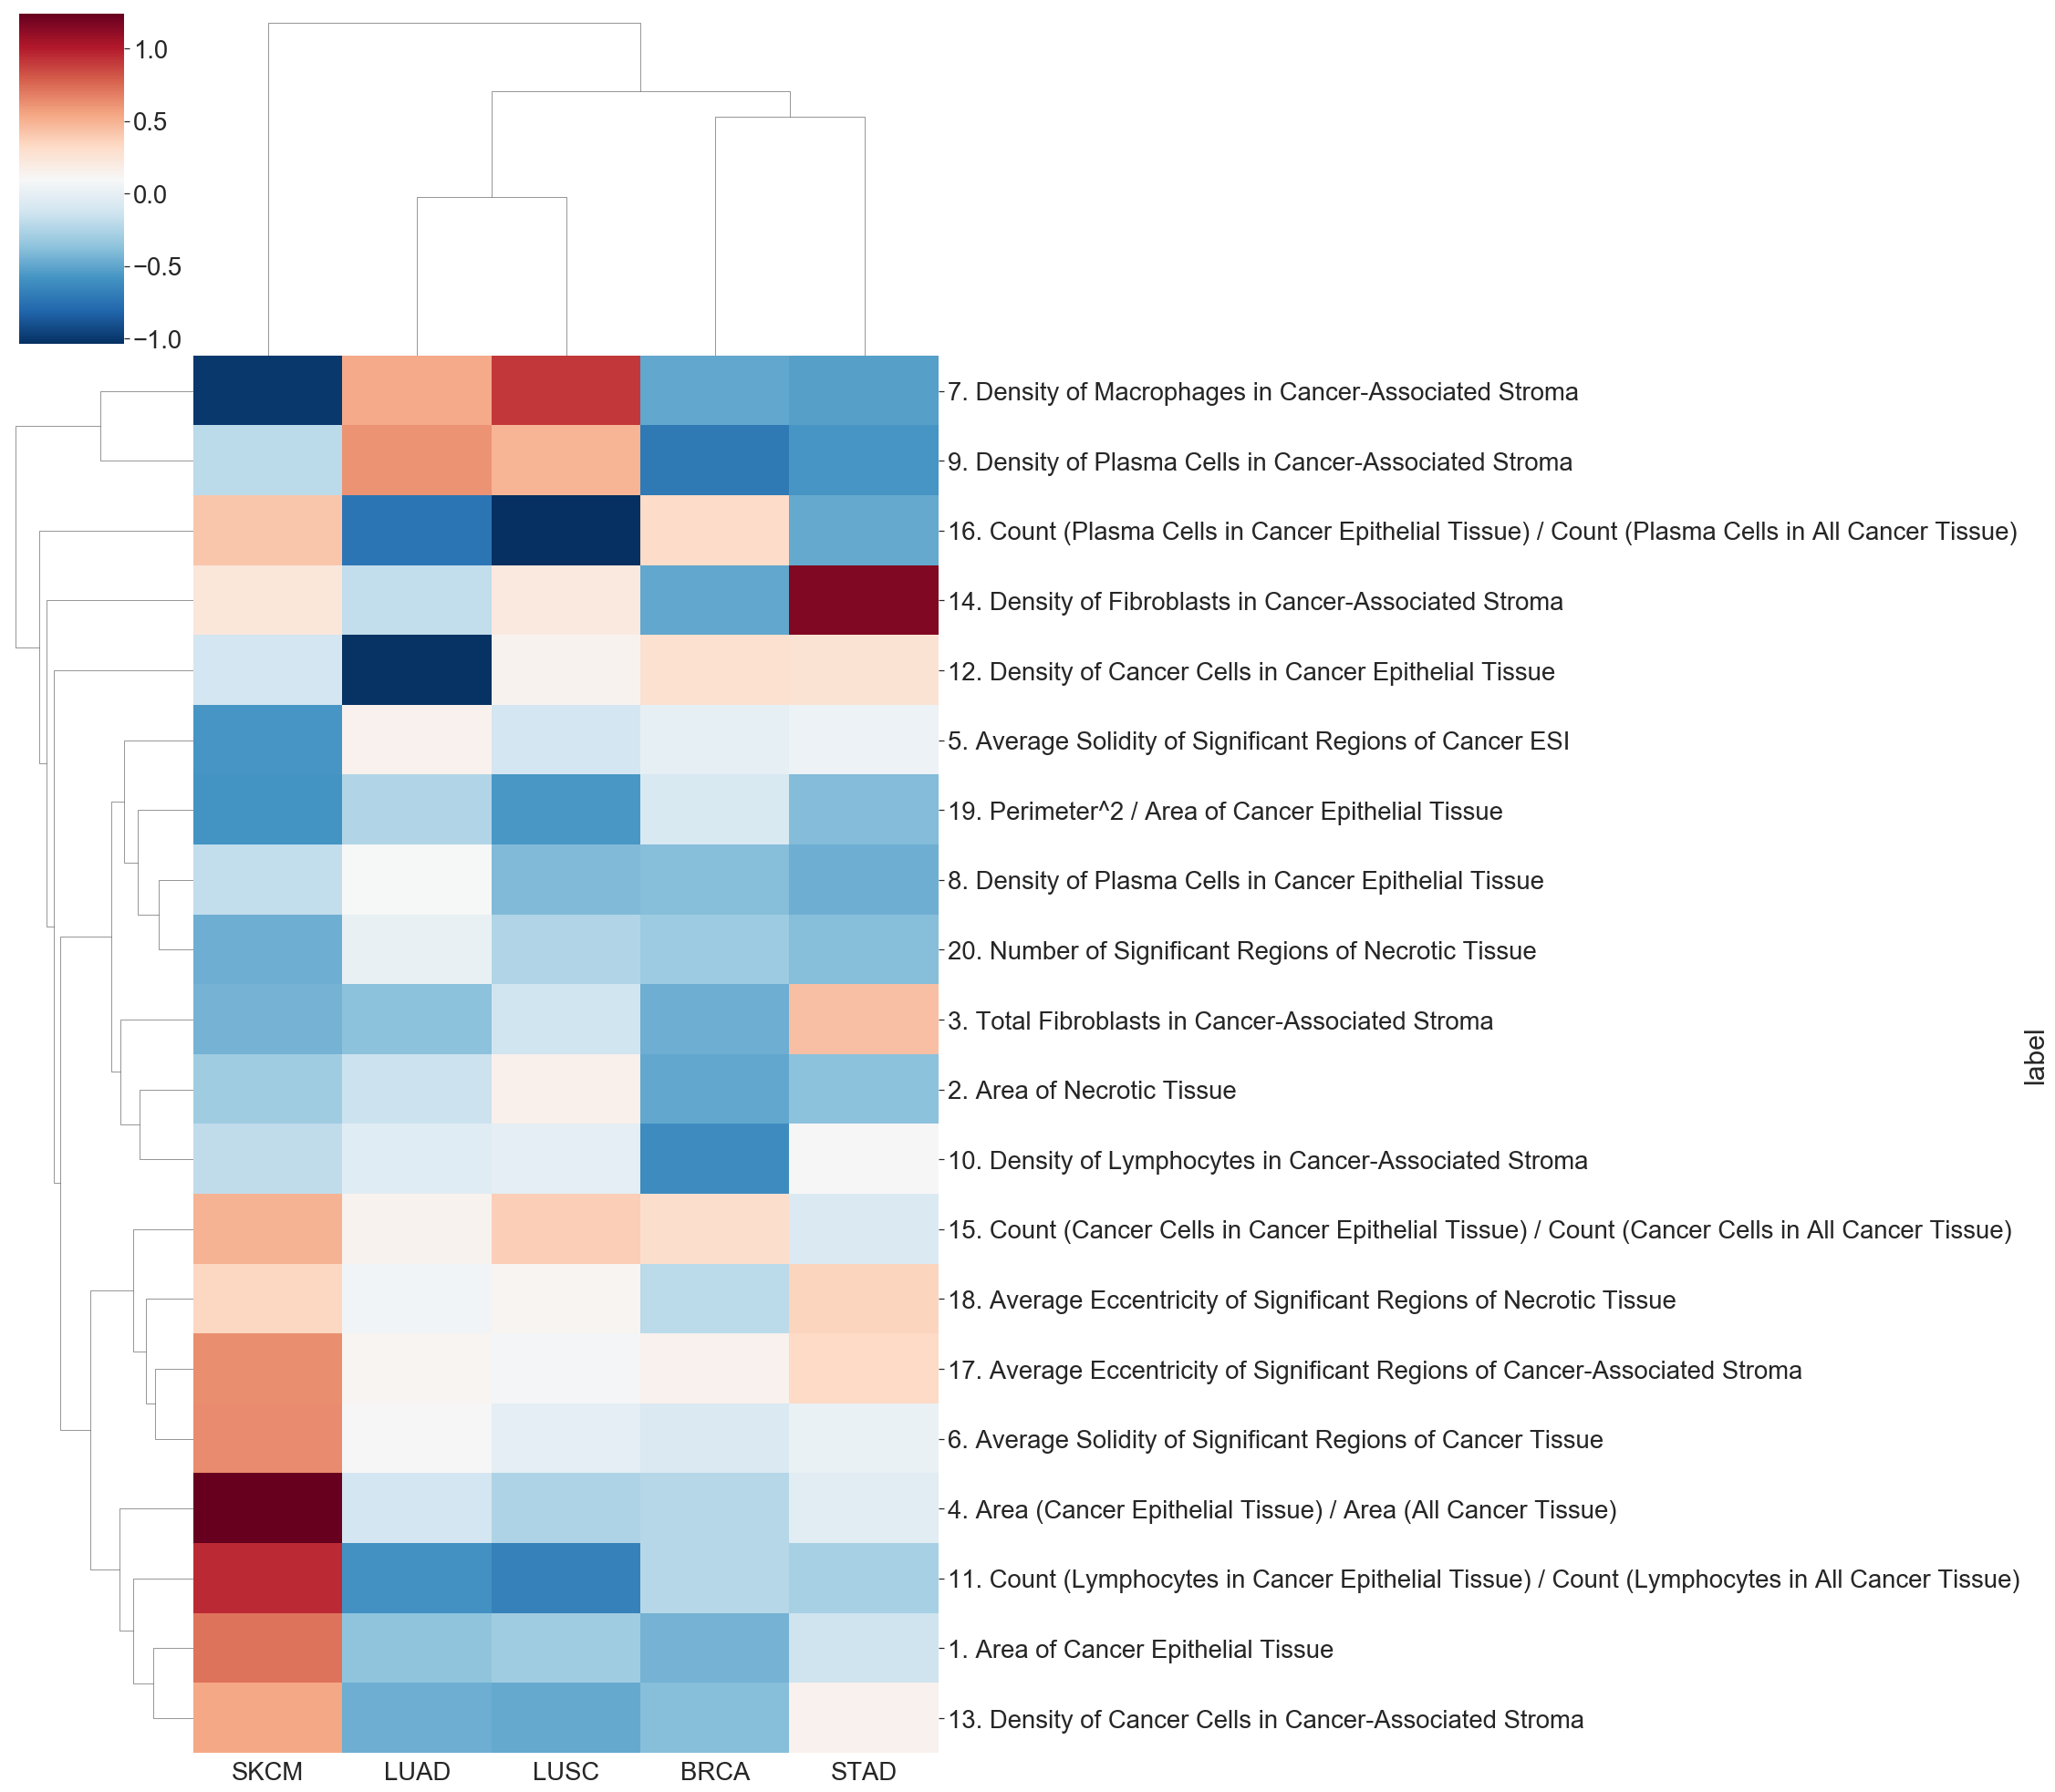

In [36]:
sns.set_style({"font.sans-serif": "Helvetica"})
sns.set(font_scale=2.5)
heatmap = sns.clustermap(heatmap_df, figsize=(32, 28), cmap='RdBu_r')

## Hypothesis Tests

In [37]:
# pancancer_df_normalized

In [38]:
hypothesis_df = pancancer_df_normalized[list(rep_hifs.values()) + ['type']]
# hypothesis_df

In [39]:
# list(rep_hifs.values())

In [41]:
# Merge LUAD + LUSC = NSCLC
hypothesis_df.loc[hypothesis_df.type == 'LUAD', 'type'] = 'NSCLC'
hypothesis_df.loc[hypothesis_df.type == 'LUSC', 'type'] = 'NSCLC'
# hypothesis_df

In [42]:
# SKCM vs. rest

# DENSITY [CANCER CELLS] IN [STROMA]_HE
p_val = mannwhitneyu(
        hypothesis_df[hypothesis_df['type'] == 'SKCM']['DENSITY [CANCER CELLS] IN [STROMA]_HE'],
        hypothesis_df[hypothesis_df['type'] != 'SKCM']['DENSITY [CANCER CELLS] IN [STROMA]_HE'],
        alternative='greater')
print(p_val)

# AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE
p_val = mannwhitneyu(
        hypothesis_df[hypothesis_df['type'] == 'SKCM']['AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE'],
        hypothesis_df[hypothesis_df['type'] != 'SKCM']['AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE'],
        alternative='greater')
print(p_val)

MannwhitneyuResult(statistic=546757.0, pvalue=4.001659839115395e-53)
MannwhitneyuResult(statistic=512212.0, pvalue=3.3447763199304004e-36)


In [43]:
# NSCLC vs rest
# DENSITY [MACROPHAGE CELLS] IN [STROMA]_HE
p_val = mannwhitneyu(
        hypothesis_df[hypothesis_df['type'] == 'NSCLC']['DENSITY [MACROPHAGE CELLS] IN [STROMA]_HE'],
        hypothesis_df[hypothesis_df['type'] != 'NSCLC']['DENSITY [MACROPHAGE CELLS] IN [STROMA]_HE'],
        alternative='greater')
print(p_val)

# DENSITY [PLASMA CELLS] IN [STROMA]_HE
p_val = mannwhitneyu(
        hypothesis_df[hypothesis_df['type'] == 'NSCLC']['DENSITY [PLASMA CELLS] IN [STROMA]_HE'],
        hypothesis_df[hypothesis_df['type'] != 'NSCLC']['DENSITY [PLASMA CELLS] IN [STROMA]_HE'],
        alternative='greater')
print(p_val)

MannwhitneyuResult(statistic=1328071.0, pvalue=3.518337532262143e-243)
MannwhitneyuResult(statistic=1312483.0, pvalue=1.1477144254078651e-230)


In [44]:
# STAD vs rest
# DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_HE
p_val = mannwhitneyu(
        hypothesis_df[hypothesis_df['type'] == 'STAD']['DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_HE'],
        hypothesis_df[hypothesis_df['type'] != 'STAD']['DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_HE'],
        alternative='greater')
print(p_val)

MannwhitneyuResult(statistic=525501.0, pvalue=2.1599504455280694e-19)
